Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.stats as stats
from tqdm.auto import tqdm
from scipy.stats import chi2_contingency

### Задание 1

##### Считываем данные

In [2]:
# Читаем файл со временем регистрации пользователя
reg_data = pd.read_csv('~/shared/problem1-reg_data.csv', sep = ';')
reg_data.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [3]:
# Читаем файл со временем входа пользователя в игру
auth_data = pd.read_csv('~/shared/problem1-auth_data.csv', sep = ';')
auth_data.head()

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


### EDA

**1. Проведем предобработку данных в таблице reg_data**

In [4]:
# Смотрим на типы данных и пропущенные значения
reg_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
reg_data[reg_data.duplicated()]

,reg_ts,uid


In [6]:
reg_data.uid.nunique()

1000000

В выборке у нас 1 млн строк, пропущенных значений нет, дубликатов нет <br>
Уникальных пользователей 1 миллион <br>
Мы видим, что данные о времени выражены в `unix timestamp`. 
Для расчета retention rate, колонку необходимо перевести в формат даты

In [7]:
reg_data['reg_date'] = pd.to_datetime(reg_data.reg_ts, unit = 's').dt.strftime('%Y-%m-%d')
reg_data.head()

,reg_ts,uid,reg_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


**2. Проведем предобработку данных в таблице auth_data**

In [8]:
auth_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


In [9]:
auth_data.shape

(9601013, 2)

In [10]:
auth_data[auth_data.duplicated()]

,auth_ts,uid


In [11]:
auth_data.uid.nunique()

1000000

В выборке у нас 9,6 млн строк, пропущенных значений нет, дубликатов нет <br>
Уникальных пользователей 1 миллион <br>
В таблице с данными о времени входа в игру, время также выражено в `unix timestamp`. 
Переводим колонку в формат даты

In [12]:
auth_data['auth_date'] = pd.to_datetime(auth_data.auth_ts, unit = 's').dt.strftime('%Y-%m-%d')
auth_data.head(5)

,auth_ts,uid,auth_date
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,932921206,2,1999-07-25
3,933393015,2,1999-07-31
4,933875379,2,1999-08-05


#### 3. Соединим таблицы reg_data и auth_data

In [13]:
df_temp = reg_data.merge(auth_data, on = 'uid', how = 'left')
df_temp.head(5)

,reg_ts,uid,reg_date,auth_ts,auth_date
0,911382223,1,1998-11-18,911382223,1998-11-18
1,932683089,2,1999-07-22,932683089,1999-07-22
2,932683089,2,1999-07-22,932921206,1999-07-25
3,932683089,2,1999-07-22,933393015,1999-07-31
4,932683089,2,1999-07-22,933875379,1999-08-05


In [14]:
df_temp.shape

(9601013, 5)

In [15]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9601013 entries, 0 to 9601012
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   reg_ts     int64 
 1   uid        int64 
 2   reg_date   object
 3   auth_ts    int64 
 4   auth_date  object
dtypes: int64(3), object(2)
memory usage: 439.5+ MB


In [16]:
# Посмотрим на минимальное и максимальное значение в поле с датой регистрации
print('registration date minimum is', df_temp.reg_date.min(),', registration date maximum is', df_temp.reg_date.max())

registration date minimum is 1998-11-18 , registration date maximum is 2020-09-23


#### Оставим только необходимые колонки

In [17]:
df_temp = df_temp[['uid','reg_date','auth_date']]
df_temp.head(5)

,uid,reg_date,auth_date
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05


Посмотрим на наши данные - визуализируем кол-во зарегистрированных пользователей по годам и кол-во юзеров, которые возвращались в игру

In [18]:
df_temp2 = df_temp.copy()

In [19]:
df_temp2['year'] = pd.to_datetime(df_temp2.reg_date).dt.strftime('%Y')

In [20]:
df_temp2['auth_year'] = pd.to_datetime(df_temp2.auth_date).dt.strftime('%Y')

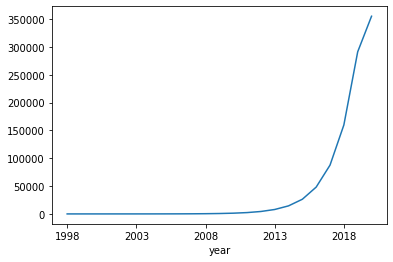

In [21]:
# Число зарегистрированных пользователей по годам
df_temp2.groupby('year')['uid'].nunique().plot()

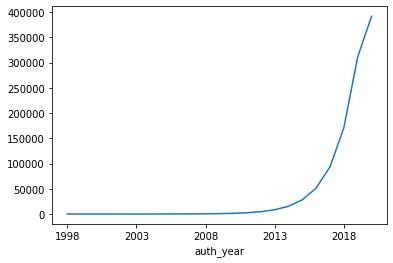

In [22]:
# Число пользователей, кто возвращался в игру в определенном году
df_temp2.groupby('auth_year')['uid'].nunique().plot()

`Retention rate` - это коэффициент удержания клиентов, который рассчитывается по когортам. 
<br> Retention rate выражается в процентах и показывает, сколько пользователей вернулись в приложение к определенному времени.
<br> В качестве когорты будем рассматривать **дату регистрации пользователя**.

- Когортный анализ можно проводить в разных разрезах: по годам, месяцам, неделям и дням.<br>
- Напишем функцию для каждого разреза данных <br>
- Для более гибкого просмотра retention rate по когортам, зададим на вход диапазон дат регистрации пользователей

##### 1. Retention Rate по периодам

Напишем функцию, которая на вход будет датафрейм, дату начала и дату конца регистрации пользователей, группировку (год, месяц или день), и максимальный размер периода (лет, месяцев или дней)


In [23]:
def retention_rate(df, reg_date_start, reg_date_end, grouping, max_period):
    # Задаем функцию, которая будет приводить к нужному виду формат данных, в зависимости от выбранной группировки
    if grouping == 'year' or grouping == 'years':
        period = 'timedelta64[Y]'
        date_format = ('%Y')
    elif grouping == 'month' or grouping == 'months':
        period = 'timedelta64[M]'
        date_format = ('%Y-%m')
    else:
        period = 'timedelta64[D]'
        date_format = ('%Y-%m-%d')
    pd.options.mode.chained_assignment = None
    # Рассчитываем разницу между датой регистрации и входом пользователя в игру
    df['time_diff'] = (pd.to_datetime(df.auth_date) - pd.to_datetime(df.reg_date)).astype(period)
    # Переводим дату регистрации в нужный формат даты, в зависимости от выбранной группировки
    df['reg_period'] = pd.to_datetime(df.reg_date).dt.strftime(date_format)
    # Фильтруем датафрейм по выбранному диапазону даты регистрации и количества дней/месяцев/лет для анализа
    df = df.query('reg_date>=@reg_date_start and reg_date<=@reg_date_end and time_diff<=@max_period')
    # Рассчитываем размер каждой когорты
    cohort_size = df.groupby('reg_period', as_index = False)['uid'].nunique()\
                    .rename(columns = {'uid':'cohort_size'})
    # Считаем кол-во пользователей для каждой когорты и времени между датой регистрации и заходом в игру
    cohorts = df.groupby(['reg_period','time_diff'], as_index = False)['uid'].nunique()\
                .rename(columns = {'uid':'group_size'})
    # Соединяем 2 таблицы выше, чтобы рассчитать retention rate
    retention_rate = cohorts.merge(cohort_size, on = 'reg_period', how = 'left')
    # Рассчитываем retention rate
    retention_rate['retention_rate'] = retention_rate['group_size']/retention_rate['cohort_size']
    # Получаем сводную таблицу с retention rate по когортам
    pivot = pd.pivot_table(retention_rate, values = 'retention_rate', index = 'reg_period', columns = 'time_diff', fill_value = 0)
    
    # Визуализируем полученные данные
    plt.figure(figsize=(15, 10))
    sns.heatmap(data=pivot, annot=True, fmt='.2%', cmap='Reds', linecolor='white', linewidths=1)\
       .set(xlabel='Days/Months/Years after Registration', ylabel='Cohort', title='Cohorts Retention rate')
    plt.show()

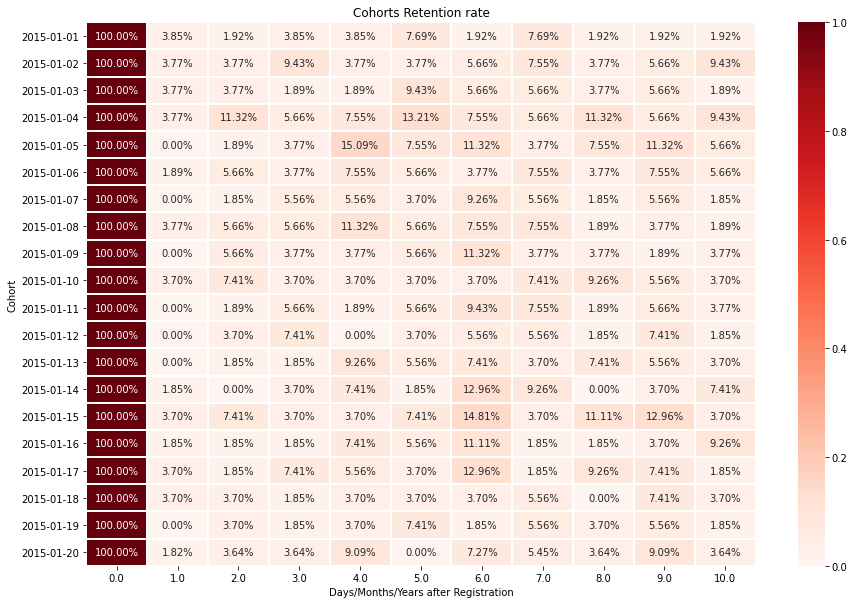

In [24]:
retention_rate(df_temp, '2015-01-01', '2015-01-20', 'days', 10)

### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

##### Подгружаем датасет

In [25]:
df = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-j-zinurova/final_project/Проект_1_Задание_2.csv', sep = ';')
df.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


##### Смотрим на типы данных, пропущенные значения

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


С типами данных все хорошо, пропущенных значений нет

Посмотрим на данные по `revenue`, `arpu`, `arppu` и `conversion rate` в каждой группе

In [27]:
# Создаем датафрейм из данных по платящим пользователям
paying = df.query('revenue>0').groupby('testgroup', as_index = False).agg({'user_id':'nunique'})\
           .rename(columns = {'user_id':'paying_users'})

In [28]:
# Формируем датасет со всеми пользователями, добавляем информацию о платящих пользователях
df1 = df.groupby('testgroup', as_index = False).agg({'user_id':'nunique', 'revenue':'sum'})\
        .merge(paying, how = 'left', on = 'testgroup')\
        .rename(columns = {'user_id':'users'})

In [29]:
df1

,testgroup,users,revenue,paying_users
0,a,202103,5136189,1928
1,b,202667,5421603,1805


In [30]:
# Рассчитываем показатели arpu, arppu и conversion rate (CR)
df1['arpu'] = df1['revenue']/df1['users']
df1['arppu'] = df1['revenue']/df1['paying_users']
df1['CR'] = df1['paying_users']/df1['users']

In [31]:
df1

,testgroup,users,revenue,paying_users,arpu,arppu,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.009540
1,b,202667,5421603,1805,26.751287,3003.658172,0.008906


Мы видим, что в контрольной группе показатели arpu и arppu ниже, чем в тестовой, однако конверсия в покупку выше у контрольной группы. <br> Посмотрим на распределение данных платящих пользователей

In [32]:
control = df.query('testgroup=="a" and revenue>0')
test = df.query('testgroup=="b" and revenue>0')

In [33]:
control.describe()

,user_id,revenue
count,1928.000000,1928.000000
mean,200152.677905,2663.998444
std,116596.504905,9049.039763
min,73.000000,200.000000
25%,99323.000000,257.000000
50%,199854.500000,311.000000
75%,299664.250000,361.000000
max,404768.000000,37433.000000


In [34]:
test.describe()

,user_id,revenue
count,1805.000000,1805.000000
mean,205834.548476,3003.658172
std,116400.045485,572.619709
min,161.000000,2000.000000
25%,106815.000000,2513.000000
50%,206651.000000,3022.000000
75%,304907.000000,3478.000000
max,404526.000000,4000.000000


Построим распределение данных на графике для каждой группы

**Контрольная группа**

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


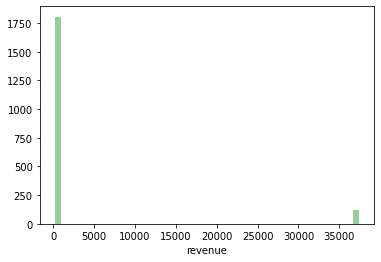

In [35]:
sns.distplot(control.revenue, color = 'green', kde = False)

In [36]:
control.query('revenue>35000')['user_id'].count()

123

In [37]:
control.query('revenue>35000')['user_id'].count()/control['user_id'].count()

0.0637966804979253

In [38]:
control.query('revenue>35000')['revenue'].sum()/control.revenue.sum()

0.8937077665950377

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


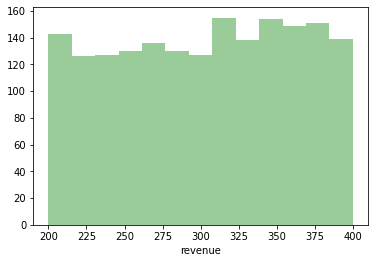

In [39]:
sns.distplot(control.query('revenue<35000').revenue, color = 'green', kde = False)

Итак, мы видим, что у большинства платящих пользователей выручка составляет меньше 400 у.е., и только у 123 пользователей выручка больше 35к у.е. Данные пользователи генерируют 89% всей выручки.

Уже можно сделать вывод о том, что распределение данных не является нормальным.

**Тестовая группа**

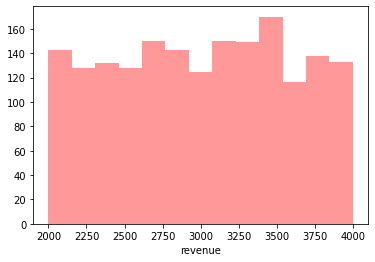

In [40]:
sns.distplot(test.revenue, color = 'red', kde = False)

Можно заметить, что в тестовой группе данные распределены более равномерно, диапазон по выручке на пользователя выше - от 2000 до 4000 у.е.

Наложим 2 графика друг на друга, чтобы нагляднее увидеть разницу распределений между контрольной и тестовой группами платящих пользователей

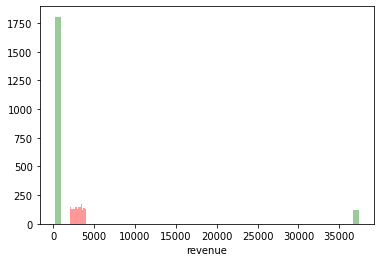

In [41]:
sns.distplot(test.revenue, color = 'red', kde = False)
sns.distplot(control.revenue, color = 'green', kde = False)

Построим боксплоты

Text(0, 0.5, 'Размер выручки')

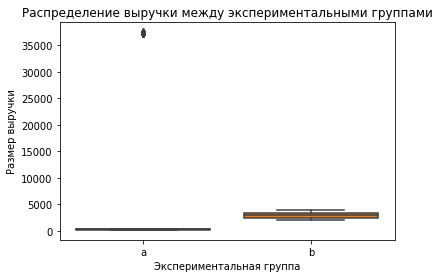

In [42]:
sns.boxplot(x = 'testgroup', y = 'revenue', data = df.query('revenue>0'))
plt.title('Распределение выручки между экспериментальными группами')
plt.xlabel('Экспериментальная группа')
plt.ylabel('Размер выручки')

- Итак, мы посмотрели на распределения данных по выручке в контрольной и тестовой выборках платящих юзеров и увидели, что в контрольной группе выручка распределена более неравномерно, а именно 89% всей выручки генерируется 6% пользоваталей, при этом основная часть пользователей приносят выручку от 200 до 400 у.е. <br>
- В тестовой же группе данные распределены более равномерно, и распределение выручки по пользователям лежит в пределах от 2000 до 4000 у.е.

Для анализа о значимости различий между выборками мы будем использовать такие продуктовые метрики как `ARPU`, `ARPPU` и `CR`.

Нам необходимо понять, являются ли различия в этих показателях статистически значимыми. Для этого еще раз посмотрим на распределения и определимся с тестом, который будем использовать.

##### 1. ARPU

Проверим дисперсии внутри наших групп. Для использования t-критерия дисперсии должны быть примерно одинаковы (требование гомогенности дисперсий). <br>
Проверить это можно с помощью критерия Левена и критерия Фишера


In [43]:
stats.levene(df.query('testgroup=="a"').revenue, df.query('testgroup=="b"').revenue, center='mean')

LeveneResult(statistic=1.57736044973474, pvalue=0.2091420343022563)

In [44]:
stats.levene(df.query('testgroup=="a"').revenue, df.query('testgroup=="b"').revenue, center='median')

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

p-значение составляет не менее 0.05, значит дисперсии гомогенны

Для применения T-критерия Стьюдента нам необходимо соблюсти требование к нормальности данных обеих групп. <br> 
Однако на практике t-тест может быть использован для сравнения средних и при ненормальном распределении, особенно на больших выборках


Дисперсии гомогенны, выборка большая => применяем t-test

In [45]:
stats.ttest_ind(df.query('testgroup=="a"').revenue, df.query('testgroup=="b"').revenue)

Ttest_indResult(statistic=-0.6242026493616787, pvalue=0.532494858971837)

pvalue>0.05 следовательно статистически значимых различий по arpu между тестовой и контрольной выборкой нет

In [46]:
df1

,testgroup,users,revenue,paying_users,arpu,arppu,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.009540
1,b,202667,5421603,1805,26.751287,3003.658172,0.008906


##### 2. ARPPU

Проверим дисперсии внутри наших групп

In [47]:
stats.levene(df.query('testgroup=="a" and revenue>0').revenue, df.query('testgroup=="b" and revenue>0').revenue, center='mean')

LeveneResult(statistic=445.9869447066088, pvalue=1.3202514573715939e-93)

p-значение составляет менее 0.05, значит дисперсии не гомогенны => Т-тест применить не можем. Используем метод бутстрап.

Бутстрэп-процедура состоит в многократном извлечении подвыборок из эмпирического распределения. 

**Гипотезы:** <br>
H0 – в генеральной совокупности никакого различия между средней выручкой нет <br>
H1 – средние по выручке в генеральной совокупности не равны (альтернативная гипотеза)

In [48]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

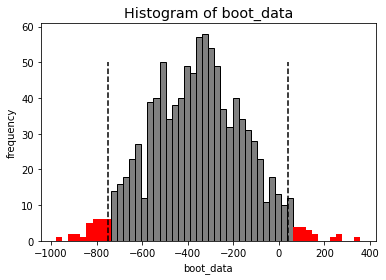

In [49]:
booted_data = get_bootstrap(df.query('testgroup=="a" and revenue>0').revenue, df.query('testgroup=="b" and revenue>0').revenue)


График выше показывает, что наш 0 входит в наш доверительный интервал. 

In [50]:
booted_data["p_value"] # альфа

0.08518730274602357

Так как p-value > 0.05 и 0 попал в доверительный интервал, мы не можем отклонить нулевую гипотезу о том, что `ARPPU` в группах значимо различаются.

##### 3. Conversion Rate

Для определения статистическо значимых различий в конверсии между группами, воспользуемся таблицей сопряженности

**Гипотезы:** <br>
H0: конверсия в тестовой и контрольной группах не различается <br>
H1: конверсия в тестовой и контрольной группах различается

In [51]:
df1

,testgroup,users,revenue,paying_users,arpu,arppu,CR
0,a,202103,5136189,1928,25.413720,2663.998444,0.009540
1,b,202667,5421603,1805,26.751287,3003.658172,0.008906


In [52]:
df1.set_index('testgroup')[['users', 'paying_users']]

,users,paying_users
testgroup,,
a,202103,1928
b,202667,1805


In [53]:
df['paying'] = df['revenue'].apply(lambda x: 'yes' if x>0 else 'no')

In [54]:
table = pd.crosstab(df.paying, df.testgroup)

In [55]:
table

testgroup,a,b
paying,,
no,200175,200862
yes,1928,1805


In [56]:
stat, p, dof, expected = stats.chi2_contingency(table)
p

0.03647561892312613

p-value < 0.05 следовательно нулевая гипотеза отвергается, поэтому мы можем сказать, что различие в конверсии в покупку между контрольной и тестовой группой является статистически значимым

### Вывод

- Для анализа результатов A/B тестирования были выбраны 3 метрики: ARPU, ARPPU и conversion rate
- На основании проведенных исследований мы выяснили, что показатели `ARPU` и `ARPPU` оказались выше в тестовой группе, однако данное различие оказалось статистически незначимо. В то же время конверсия в покупку `conversion rate` оказалась выше в контрольной группе, при этом различие казалось статически значимым.

- На основании выводов о `conversion rate` можно сказать, что набор акций неблагоприятно сказался на конверсии в покупку у тестовой группы, где количество платящих пользователей стало ниже, а размер тестовой группы оказался выше, чем в контрольной. При этом данный показатель игнорирует размер выручки, который в тестовой группе оказался выше.

- Так как конверсия в покупку у тестовой группы оказалась ниже, и данное различие статистически значимо, следовательно, стоит оставить набор акционных предложений контрольной группы.


### Задание 3

*В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?*

Как гласит условие, тематические события дают ряд преимуществ или бонусов для игроков, которые в них участвуют. Соответственно логично предположить, что такие события могут сопровождаться ростом числа игроков, увеличением длины сессии, вовлеченности, и, возможно, приведут к росту выручки


**Показатели, которые позволят отследить рост числа игроков**
- DAU/WAU/MAU - покажут число активных юзеров за период
- avg DAU/MAU (или stickiness ratio) - покажет частоту, с которой пользователь взаимодействует с приложением
- Share of new users - отношение числа новых пользователей за какой-то промежуток времени ко всем пользователям за этот же промежуток времени

**Показатели, которые позволят отследить кол-во сессий и их продолжительность**
- Average Session Duration - средняя длина сессии на юзера
- Session Number - количество сессий

**Показатели, которые позволят отследить увеличение вовлеченности и выручки**
- ARPU, ARPPU - средняя выручка на юзера/платящего юзера
- Retenion Rate - коэффициент удержания клиентов
- Средний чек - размер среднего чека

*Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?*


Усложнение механики потенциально может вызвать отток клиентов, в этом случае необходимо дополнительно отслеживать показатель `Churn Rate`. Это метрика, обратная retention, показывает коэффициент оттока пользователей.